In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("FINAL_USO.csv")

df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
0,2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
1,2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2,2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
3,2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
4,2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000
5,2011-12-22,156.350006,156.800003,155.330002,156.039993,156.039993,9888400,124.629997,125.400002,124.230003,...,51.770000,52.400002,49.656178,13179600,38.270000,38.549999,38.209999,38.279999,38.279999,5376800
6,2011-12-23,156.350006,156.490005,155.820007,156.309998,156.309998,3565100,125.669998,126.430000,125.410004,...,52.349998,52.790001,50.169365,4729000,38.470001,38.610001,38.369999,38.490002,38.490002,2162200
7,2011-12-27,155.080002,155.550003,154.539993,154.910004,154.910004,4918600,126.169998,126.820000,126.059998,...,51.680000,51.869999,49.295036,4786400,38.490002,39.209999,38.459999,39.060001,39.060001,7834100
8,2011-12-28,154.050003,154.259995,150.660004,151.029999,151.029999,16436100,126.510002,126.529999,124.730003,...,50.009998,50.060001,47.574883,14170400,38.880001,38.889999,38.189999,38.340000,38.340000,5654300
9,2011-12-29,149.089996,150.720001,148.270004,150.339996,150.339996,19812200,125.239998,126.250000,124.860001,...,49.220001,51.200001,48.658298,12196600,38.389999,38.459999,37.869999,38.410000,38.410000,8924300


<Axes: >

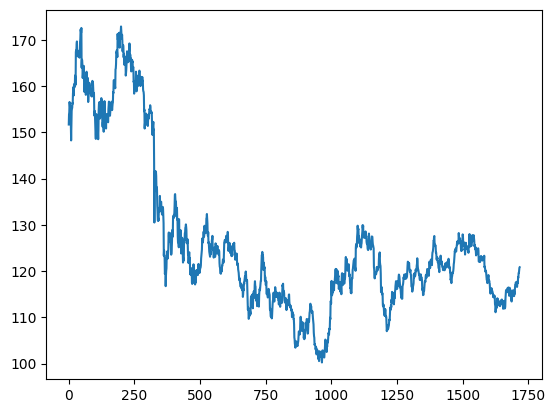

In [3]:
df['Low'].plot()

In [4]:
df['Low'].values

array([151.710007, 153.899994, 154.360001, ..., 120.139999, 120.720001,
       120.830002])

In [5]:
def sliding_window(data, seq_length):
    x = []
    y = []
    
    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        
        x.append(_x)
        y.append(_y)
        
    return np.array(x), np.array(y)

seq_length = 5
x, y = sliding_window(df['Low'].values, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [6]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.hidden = nn.Linear(input_dim, 25)
        self.output = nn.Linear(25, output_dim)

    def forward(self, x):
        # f(x) = a(f(x))
        x = F.relu(self.hidden(x))
        y = F.relu(self.output(x))
        #y = F.softmax(y, dim=-1)

        return y

In [7]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        self.n_samples = len(x)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
    
training_ds = CustomDataset(trainX, trainY)

In [8]:
from torch.utils.data import DataLoader

batch_size = 5

train_loader = DataLoader(
    training_ds,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)

In [9]:
num_epochs = 100
learning_rate = 0.01
num_classes = 1
#lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm = MultiLayerPerceptron(seq_length, num_classes)
print(lstm(trainX))

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    #if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

lstm.eval()
predictions = lstm(testX).detach().numpy()

predictions = predictions.ravel()

predictions

tensor([[47.0303],
        [47.0756],
        [47.3552],
        ...,
        [38.4143],
        [38.0314],
        [38.0205]], grad_fn=<ReluBackward0>)
Epoch: 0, loss: 8668.97656
Epoch: 1, loss: 6436.82275
Epoch: 2, loss: 4485.60938
Epoch: 3, loss: 2938.02563
Epoch: 4, loss: 1777.13635
Epoch: 5, loss: 1041.64050
Epoch: 6, loss: 785.88226
Epoch: 7, loss: 976.63751
Epoch: 8, loss: 1428.34119
Epoch: 9, loss: 1851.94324
Epoch: 10, loss: 2043.67944
Epoch: 11, loss: 1972.54785
Epoch: 12, loss: 1719.88367
Epoch: 13, loss: 1398.50403
Epoch: 14, loss: 1104.42004
Epoch: 15, loss: 897.18231
Epoch: 16, loss: 797.51917
Epoch: 17, loss: 793.23590
Epoch: 18, loss: 850.98608
Epoch: 19, loss: 937.20697
Epoch: 20, loss: 1021.79517
Epoch: 21, loss: 1082.99536
Epoch: 22, loss: 1109.18970
Epoch: 23, loss: 1098.30017
Epoch: 24, loss: 1055.90540
Epoch: 25, loss: 992.81323
Epoch: 26, loss: 922.46252
Epoch: 27, loss: 858.30328
Epoch: 28, loss: 811.29547
Epoch: 29, loss: 787.79834
Epoch: 30, loss: 788.29102
Ep

/home/ralampay/workspace/pattern-recognition-course/env/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1147])) that is different to the input size (torch.Size([1147, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 56, loss: 794.59052
Epoch: 57, loss: 794.98602
Epoch: 58, loss: 793.56732
Epoch: 59, loss: 790.95917
Epoch: 60, loss: 788.09650
Epoch: 61, loss: 785.84802
Epoch: 62, loss: 784.73425
Epoch: 63, loss: 784.80811
Epoch: 64, loss: 785.72418
Epoch: 65, loss: 786.92468
Epoch: 66, loss: 787.86261
Epoch: 67, loss: 788.18420
Epoch: 68, loss: 787.81360
Epoch: 69, loss: 786.93121
Epoch: 70, loss: 785.87024
Epoch: 71, loss: 784.97675
Epoch: 72, loss: 784.48596
Epoch: 73, loss: 784.45581
Epoch: 74, loss: 784.77112
Epoch: 75, loss: 785.21265
Epoch: 76, loss: 785.55359
Epoch: 77, loss: 785.64661
Epoch: 78, loss: 785.46448
Epoch: 79, loss: 785.09210
Epoch: 80, loss: 784.67517
Epoch: 81, loss: 784.35229
Epoch: 82, loss: 784.20355
Epoch: 83, loss: 784.22919
Epoch: 84, loss: 784.36420
Epoch: 85, loss: 784.51343
Epoch: 86, loss: 784.59467
Epoch: 87, loss: 784.56781
Epoch: 88, loss: 784.44281
Epoch: 89, loss: 784.26788
Epoch: 90, loss: 784.10413
Epoch: 91, loss: 783.99750
Epoch: 92, loss: 783.96448
E

array([122.45449 , 122.4011  , 122.56562 , 123.21864 , 123.62226 ,
       124.001915, 123.91888 , 123.84414 , 123.47354 , 123.091805,
       122.63108 , 120.941666, 120.1829  , 118.79707 , 117.74375 ,
       117.111336, 116.79887 , 116.65254 , 116.77364 , 116.81107 ,
       116.89629 , 116.928215, 117.43256 , 117.44999 , 117.68972 ,
       117.65531 , 118.009995, 117.863014, 117.967834, 117.96603 ,
       118.73323 , 119.27208 , 119.69778 , 120.34104 , 120.0287  ,
       119.89203 , 119.34685 , 118.46027 , 116.36138 , 115.73802 ,
       114.89431 , 113.91224 , 113.06331 , 113.074425, 112.82097 ,
       111.751015, 111.269844, 110.93695 , 110.566216, 109.758804,
       109.28979 , 109.43121 , 108.699554, 108.76994 , 108.75714 ,
       108.92459 , 108.387634, 108.43676 , 108.179794, 107.41241 ,
       106.4287  , 106.10764 , 105.945114, 105.30573 , 105.28591 ,
       105.23452 , 105.43639 , 105.44809 , 105.626625, 106.037796,
       106.38656 , 106.63238 , 107.24788 , 108.08155 , 108.365

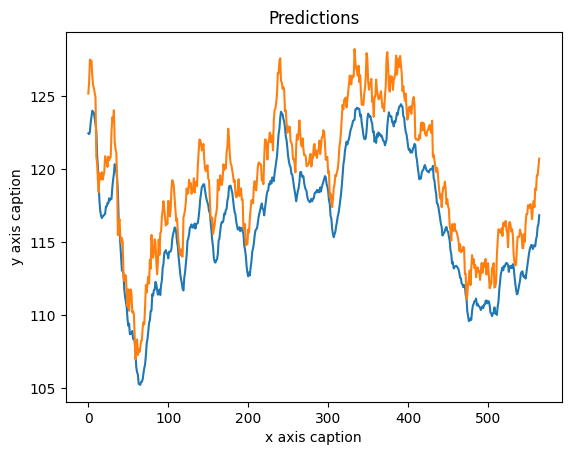

In [10]:
x_axis_values = np.arange(0,len(predictions)) 
plt.title("Predictions") 
plt.xlabel("x axis caption") 
plt.ylabel("y axis caption") 
plt.plot(x_axis_values,predictions) 
plt.plot(x_axis_values,testY) 
plt.show()